# QHM6702 Deep Learning with Neural Networks
# Deep Learning for Fashion-MNIST Classification with Transfer Learning

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import resnet50, ResNet50_Weights
import gzip
import struct
import time
from tqdm import tqdm
import torchvision.transforms as transforms
from PIL import Image
from torch.cuda.amp import autocast, GradScaler

In [2]:
# 设置随机种子，确保结果可复现
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 检查是否有可用的GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")



使用设备: cuda:0


In [4]:
# 创建保存模型和记录的目录
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# 定义Fashion-MNIST数据集的类别
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 加载Fashion-MNIST数据集
def load_mnist(images_path, labels_path):
    # 读取图像
    with gzip.open(images_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, rows, cols)
    
    # 读取标签
    with gzip.open(labels_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    
    return images, labels

# 加载训练集和测试集
print("正在加载Fashion-MNIST数据集...")
train_images, train_labels = load_mnist('data/train-images-idx3-ubyte.gz', 'data/train-labels-idx1-ubyte.gz')
test_images, test_labels = load_mnist('data/t10k-images-idx3-ubyte.gz', 'data/t10k-labels-idx1-ubyte.gz')

print(f"训练集: {train_images.shape} 图像, {train_labels.shape} 标签")
print(f"测试集: {test_images.shape} 图像, {test_labels.shape} 标签")

正在加载Fashion-MNIST数据集...
训练集: (60000, 28, 28) 图像, (60000,) 标签
测试集: (10000, 28, 28) 图像, (10000,) 标签


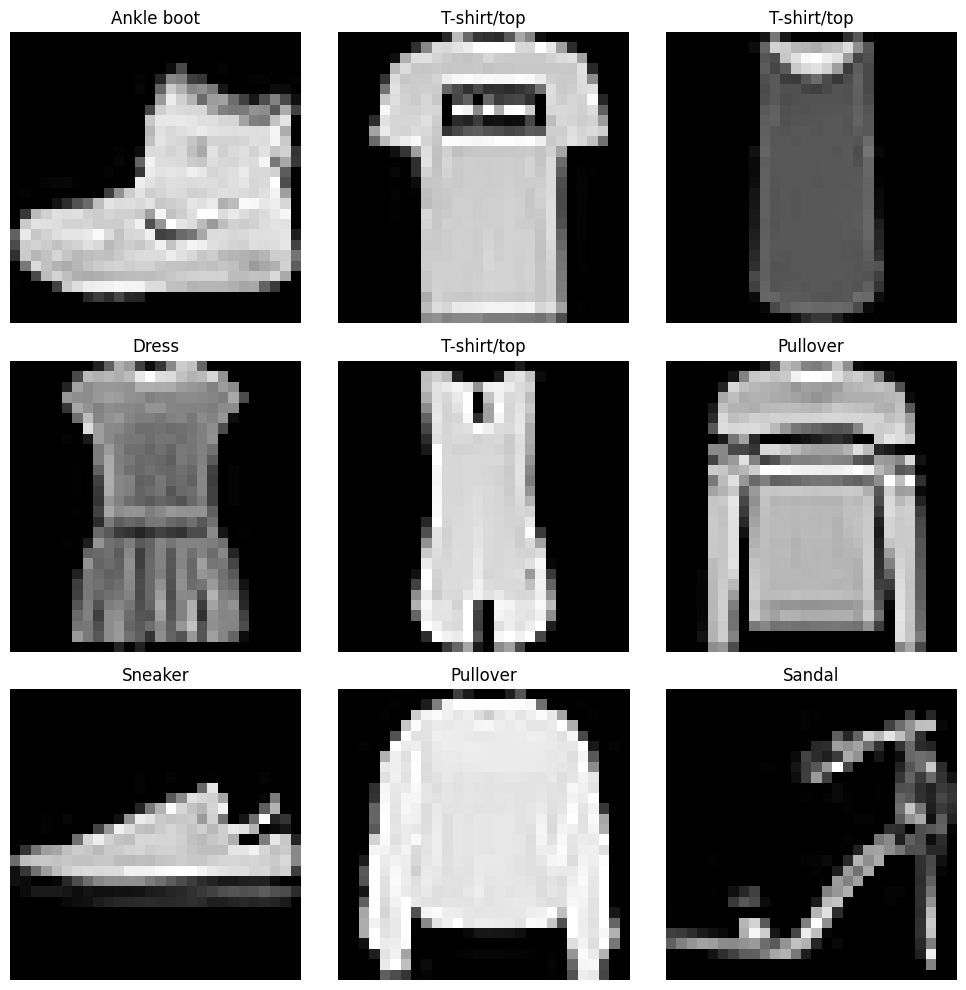

In [5]:
# 可视化一些数据样本
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.savefig('results/data_samples.png')

In [6]:
# 数据预处理函数 - 上采样到112x112（小于224x224以加快处理速度，但大于96x96以适应ResNet50）
def preprocess_images(images):
    processed_images = []
    transform = transforms.Compose([
        transforms.Resize((112, 112), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
    ])
    
    for img in images:
        # 转换为PIL图像
        pil_img = Image.fromarray(img, mode='L')
        # 应用变换
        tensor_img = transform(pil_img)
        processed_images.append(tensor_img)
    
    # 将列表转换为张量
    return torch.stack(processed_images)

# 定义预处理流程 - 使用批处理减少内存使用
def batch_preprocess(images, batch_size=5000):
    all_processed = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size > 0 else 0)
    
    for i in tqdm(range(num_batches), desc="预处理图像"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        processed_batch = preprocess_images(batch_images)
        all_processed.append(processed_batch)
    
    return torch.cat(all_processed)

# 预处理数据
print("正在预处理数据...")
X_train_tensor = batch_preprocess(train_images)
X_test_tensor = batch_preprocess(test_images)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

print(f"处理后训练图像形状: {X_train_tensor.shape}")
print(f"处理后测试图像形状: {X_test_tensor.shape}")


正在预处理数据...


预处理图像:   0%|          | 0/12 [00:00<?, ?it/s]

预处理图像: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

处理后训练图像形状: torch.Size([60000, 1, 112, 112])
处理后测试图像形状: torch.Size([10000, 1, 112, 112])


In [7]:
# 创建训练数据集和验证数据集
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# 从训练集中划分验证集（80%训练，20%验证）
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# 创建测试数据集
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 打印数据集大小
print(f"训练子集大小: {len(train_subset)} 样本")
print(f"验证子集大小: {len(val_subset)} 样本")
print(f"测试集大小: {len(test_dataset)} 样本")

训练子集大小: 48000 样本
验证子集大小: 12000 样本
测试集大小: 10000 样本


In [8]:
# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size*2, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False, num_workers=4, pin_memory=True)

# 定义MobileNetV2迁移学习模型
class MobileNetTransferLearning(nn.Module):
    def __init__(self, num_classes=10, trainable_layers=0):
        super(MobileNetTransferLearning, self).__init__()
        # 加载预训练的MobileNetV2模型
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        
        # 修改第一层卷积以接受单通道输入
        original_conv = self.model.features[0][0]
        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        # 初始化权重 - 通过将原始权重求和到新通道
        with torch.no_grad():
            self.model.features[0][0].weight[:, 0:1, :, :] = original_conv.weight.sum(dim=1, keepdim=True)
        
        # 冻结指定层数的参数
        total_params = len(list(self.model.parameters()))
        if trainable_layers > 0:
            print(f"MobileNetV2: 解冻最后 {trainable_layers} 层进行微调，共 {total_params} 层")
        else:
            print(f"MobileNetV2: 冻结所有预训练层，仅训练分类器")
            
        trainable_count = 0
        for i, param in enumerate(self.model.parameters()):
            if i < total_params - trainable_layers:
                param.requires_grad = False
            else:
                param.requires_grad = True
                trainable_count += 1
        
        print(f"共 {trainable_count} 个层被解冻进行训练")
        
        # 修改分类器以适应新的类别数
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [9]:
# 定义ResNet50迁移学习模型
class ResNet50TransferLearning(nn.Module):
    def __init__(self, num_classes=10, trainable_layers=0):
        super(ResNet50TransferLearning, self).__init__()
        # 加载预训练的ResNet50模型
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # 修改第一层卷积以接受单通道输入
        original_conv = self.model.conv1
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # 初始化权重 - 通过将原始权重求和到新通道
        with torch.no_grad():
            self.model.conv1.weight[:, 0:1, :, :] = original_conv.weight.sum(dim=1, keepdim=True)
        
        # 冻结指定层数的参数
        total_params = len(list(self.model.parameters()))
        if trainable_layers > 0:
            print(f"ResNet50: 解冻最后 {trainable_layers} 层进行微调，共 {total_params} 层")
        else:
            print(f"ResNet50: 冻结所有预训练层，仅训练分类器")
            
        trainable_count = 0
        for i, param in enumerate(self.model.parameters()):
            if i < total_params - trainable_layers:
                param.requires_grad = False
            else:
                param.requires_grad = True
                trainable_count += 1
        
        print(f"共 {trainable_count} 个层被解冻进行训练")
        
        # 修改分类器以适应新的类别数
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [10]:
# 计算模型的可训练参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 早停机制
class EarlyStopping:
    def __init__(self, patience=3, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
    
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [11]:
# 训练函数 - 使用混合精度训练和梯度累积
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=5, model_name='model', accumulation_steps=2):
    # 创建早停对象
    early_stopping = EarlyStopping(patience=2, path=f'models/{model_name}_best.pth')
    
    # 使用混合精度训练
    scaler = GradScaler()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # 训练阶段
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # 重置梯度
        optimizer.zero_grad()
        
        # 添加进度条
        pbar = tqdm(train_loader, desc=f"训练 Epoch {epoch+1}")
        for i, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # 使用混合精度训练
            with autocast():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels) / accumulation_steps  # 缩放损失
            
            # 使用梯度缩放器进行反向传播
            scaler.scale(loss).backward()
            
            # 梯度累积 - 每accumulation_steps步更新一次参数
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            running_loss += loss.item() * inputs.size(0) * accumulation_steps
            running_corrects += torch.sum(preds == labels.data)
            
            # 更新进度条
            pbar.set_postfix({'batch_loss': loss.item() * accumulation_steps})
        
        # 处理最后一批可能不满accumulation_steps的情况
        if (i + 1) % accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # 验证阶段
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="验证"):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                # 验证时不需要混合精度
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())
        
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        
        # 学习率调整
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
        
        # 早停检查
        early_stopping(epoch_val_loss, model)
        if early_stopping.early_stop:
            print(f"早停在 epoch {epoch+1}")
            break
    
    training_time = time.time() - start_time
    print(f'训练完成，耗时 {training_time/60:.2f} 分钟')
    
    # 加载最佳模型
    model.load_state_dict(torch.load(f'models/{model_name}_best.pth'))
    return model, history, training_time

In [12]:
# 评估函数
def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="测试评估"):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # 对较大的输入批次分批处理以避免内存不足
            batch_size = inputs.size(0)
            if batch_size > 64:
                outputs_list = []
                for i in range(0, batch_size, 64):
                    end_idx = min(i + 64, batch_size)
                    batch_outputs = model(inputs[i:end_idx])
                    outputs_list.append(batch_outputs)
                outputs = torch.cat(outputs_list, dim=0)
            else:
                outputs = model(inputs)
                
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = running_corrects.double() / len(test_loader.dataset)
    
    # 计算每个类别的准确率
    class_accuracies = []
    for i in range(10):  # 10个类别
        class_mask = np.array(all_labels) == i
        if np.sum(class_mask) > 0:  # 确保该类别有样本
            class_acc = np.mean(np.array(all_preds)[class_mask] == i)
            class_accuracies.append((class_names[i], class_acc))
    
    return test_acc.item(), class_accuracies

In [13]:
# 训练并评估模型
def train_and_evaluate_model(model_class, model_name, trainable_layers):
    print(f"\n========== 训练 {model_name} 模型 (可训练层数: {trainable_layers}) ==========")
    
    # 创建模型
    model = model_class(num_classes=10, trainable_layers=trainable_layers)
    model = model.to(device)
    
    # 计算可训练参数数量
    trainable_params = count_parameters(model)
    print(f"可训练参数数量: {trainable_params:,}")
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    
    # 使用AdamW优化器
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=0.002,
        weight_decay=0.01
    )
    
    # 使用OneCycleLR学习率调度器
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.02,
        steps_per_epoch=len(train_loader) // 2,  # 考虑到梯度累积
        epochs=5
    )
    
    # 训练模型
    model, history, training_time = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler, num_epochs=5,
        model_name=f'{model_name}_trainable_{trainable_layers}',
        accumulation_steps=2  # 梯度累积步数
    )
    
    # 评估模型
    test_acc, class_accuracies = evaluate_model(model, test_loader)
    print(f"测试集总体准确率: {test_acc:.4f}")
    
    # 打印每个类别的准确率
    print("各类别准确率:")
    for class_name, acc in class_accuracies:
        print(f"  {class_name}: {acc:.4f}")
    
    # 绘制训练历史
    plt.figure(figsize=(12, 5))
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='训练准确率')
    plt.plot(history['val_acc'], label='验证准确率')
    plt.axhline(y=test_acc, color='r', linestyle='-', label=f'测试准确率: {test_acc:.4f}')
    plt.title(f'{model_name} 模型准确率')
    plt.xlabel('Epochs')
    plt.ylabel('准确率')
    plt.legend()
    
    # 绘制损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='训练损失')
    plt.plot(history['val_loss'], label='验证损失')
    plt.title(f'{model_name} 模型损失')
    plt.xlabel('Epochs')
    plt.ylabel('损失')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_trainable_{trainable_layers}_history.png')
    
    # 绘制类别准确率条形图
    plt.figure(figsize=(10, 6))
    classes = [ca[0] for ca in class_accuracies]
    accs = [ca[1] for ca in class_accuracies]
    plt.bar(classes, accs)
    plt.axhline(y=test_acc, color='r', linestyle='-', label=f'平均: {test_acc:.4f}')
    plt.title(f'{model_name} (可训练层: {trainable_layers}) - 各类别准确率')
    plt.xticks(rotation=45)
    plt.ylabel('准确率')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_trainable_{trainable_layers}_class_acc.png')
    
    # 记录结果
    results = {
        'model_name': model_name,
        'trainable_layers': trainable_layers,
        'trainable_params': trainable_params,
        'training_time': training_time,
        'test_accuracy': test_acc,
        'class_accuracies': class_accuracies,
        'epochs': len(history['train_acc']),
        'best_val_accuracy': max(history['val_acc']),
        'best_val_loss': min(history['val_loss']),
    }
    
    return results

# 运行迁移学习实验
print("\n开始优化的迁移学习实验...\n")




开始优化的迁移学习实验...




========== 训练 MobileNetV2 模型 (可训练层数: 0) ==========
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Drchennnn/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:24<00:00, 578kB/s] 
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\1212694963.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


MobileNetV2: 冻结所有预训练层，仅训练分类器
共 0 个层被解冻进行训练
可训练参数数量: 12,810
Epoch 1/5
----------


训练 Epoch 1:   0%|          | 0/1500 [00:00<?, ?it/s]C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\1212694963.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
训练 Epoch 1: 100%|██████████| 1500/1500 [00:41<00:00, 36.08it/s, batch_loss=0.368]


Train Loss: 0.5929 Acc: 0.7955


验证: 100%|██████████| 188/188 [00:07<00:00, 25.49it/s]


Val Loss: 0.4559 Acc: 0.8377
Epoch 2/5
----------


训练 Epoch 2: 100%|██████████| 1500/1500 [00:39<00:00, 37.74it/s, batch_loss=0.395]


Train Loss: 0.4712 Acc: 0.8317


验证: 100%|██████████| 188/188 [00:07<00:00, 26.73it/s]


Val Loss: 0.4306 Acc: 0.8427
Epoch 3/5
----------


训练 Epoch 3: 100%|██████████| 1500/1500 [00:37<00:00, 39.48it/s, batch_loss=0.602]


Train Loss: 0.4579 Acc: 0.8353


验证: 100%|██████████| 188/188 [00:07<00:00, 26.23it/s]


Val Loss: 0.3980 Acc: 0.8586
Epoch 4/5
----------


训练 Epoch 4: 100%|██████████| 1500/1500 [00:38<00:00, 39.23it/s, batch_loss=0.505] 


Train Loss: 0.4478 Acc: 0.8396


验证: 100%|██████████| 188/188 [00:07<00:00, 25.76it/s]


Val Loss: 0.4019 Acc: 0.8554
EarlyStopping counter: 1 out of 2
Epoch 5/5
----------


训练 Epoch 5: 100%|██████████| 1500/1500 [00:38<00:00, 38.72it/s, batch_loss=0.385]


Train Loss: 0.4467 Acc: 0.8400


验证: 100%|██████████| 188/188 [00:07<00:00, 26.64it/s]


Val Loss: 0.3909 Acc: 0.8586
训练完成，耗时 3.87 分钟


测试评估: 100%|██████████| 157/157 [00:06<00:00, 24.36it/s]
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:70: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:70: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:70: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:70: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:70: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppDa

测试集总体准确率: 0.8583
各类别准确率:
  T-shirt/top: 0.8020
  Trouser: 0.9760
  Pullover: 0.7510
  Dress: 0.8540
  Coat: 0.7850
  Sandal: 0.9540
  Shirt: 0.6250
  Sneaker: 0.9150
  Bag: 0.9760
  Ankle boot: 0.9450


C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:71: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.savefig(f'results/{model_name}_trainable_{trainable_layers}_history.png')
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:71: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.savefig(f'results/{model_name}_trainable_{trainable_layers}_history.png')
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:71: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.savefig(f'results/{model_name}_trainable_{trainable_layers}_history.png')
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\483367330.py:71: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.savefig(f'results/{model_name}_trainable_{trainable_layers}_history.png')
C:\Users\Drchennnn\AppData\L


========== 训练 MobileNetV2 模型 (可训练层数: 5) ==========
MobileNetV2: 解冻最后 5 层进行微调，共 158 层
共 5 个层被解冻进行训练
可训练参数数量: 424,970
Epoch 1/5
----------


训练 Epoch 1: 100%|██████████| 1500/1500 [00:39<00:00, 37.99it/s, batch_loss=0.489] 


Train Loss: 0.4701 Acc: 0.8304


验证: 100%|██████████| 188/188 [00:07<00:00, 25.89it/s]


Val Loss: 0.3780 Acc: 0.8647
Epoch 2/5
----------


训练 Epoch 2: 100%|██████████| 1500/1500 [00:39<00:00, 38.37it/s, batch_loss=0.304] 


Train Loss: 0.3616 Acc: 0.8675


验证: 100%|██████████| 188/188 [00:07<00:00, 25.58it/s]


Val Loss: 0.3340 Acc: 0.8792
Epoch 3/5
----------


训练 Epoch 3: 100%|██████████| 1500/1500 [00:38<00:00, 38.68it/s, batch_loss=0.487] 


Train Loss: 0.3254 Acc: 0.8808


验证: 100%|██████████| 188/188 [00:07<00:00, 24.17it/s]


Val Loss: 0.3326 Acc: 0.8797
Epoch 4/5
----------


训练 Epoch 4: 100%|██████████| 1500/1500 [00:42<00:00, 35.18it/s, batch_loss=0.284] 


Train Loss: 0.2947 Acc: 0.8921


验证: 100%|██████████| 188/188 [00:07<00:00, 23.75it/s]


Val Loss: 0.3323 Acc: 0.8799
Epoch 5/5
----------


训练 Epoch 5: 100%|██████████| 1500/1500 [00:40<00:00, 36.68it/s, batch_loss=0.441] 


Train Loss: 0.2727 Acc: 0.9001


验证: 100%|██████████| 188/188 [00:07<00:00, 23.90it/s]


Val Loss: 0.3157 Acc: 0.8879
训练完成，耗时 3.99 分钟


测试评估: 100%|██████████| 157/157 [00:07<00:00, 22.22it/s]


测试集总体准确率: 0.8866
各类别准确率:
  T-shirt/top: 0.8740
  Trouser: 0.9740
  Pullover: 0.8600
  Dress: 0.8930
  Coat: 0.8020
  Sandal: 0.9330
  Shirt: 0.6330
  Sneaker: 0.9700
  Bag: 0.9810
  Ankle boot: 0.9460

========== 训练 ResNet50 模型 (可训练层数: 0) ==========
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Drchennnn/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [05:00<00:00, 341kB/s] 


ResNet50: 冻结所有预训练层，仅训练分类器
共 0 个层被解冻进行训练
可训练参数数量: 20,490
Epoch 1/5
----------


训练 Epoch 1: 100%|██████████| 1500/1500 [00:38<00:00, 38.47it/s, batch_loss=0.346]


Train Loss: 0.6048 Acc: 0.7909


验证: 100%|██████████| 188/188 [00:11<00:00, 16.21it/s]


Val Loss: 0.4592 Acc: 0.8368
Epoch 2/5
----------


训练 Epoch 2: 100%|██████████| 1500/1500 [00:40<00:00, 37.24it/s, batch_loss=0.33] 


Train Loss: 0.4816 Acc: 0.8290


验证: 100%|██████████| 188/188 [00:12<00:00, 15.27it/s]


Val Loss: 0.4405 Acc: 0.8447
Epoch 3/5
----------


训练 Epoch 3: 100%|██████████| 1500/1500 [00:44<00:00, 33.90it/s, batch_loss=0.663] 


Train Loss: 0.4519 Acc: 0.8386


验证: 100%|██████████| 188/188 [00:12<00:00, 15.08it/s]


Val Loss: 0.4515 Acc: 0.8380
EarlyStopping counter: 1 out of 2
Epoch 4/5
----------


训练 Epoch 4: 100%|██████████| 1500/1500 [00:43<00:00, 34.72it/s, batch_loss=0.318]


Train Loss: 0.4337 Acc: 0.8441


验证: 100%|██████████| 188/188 [00:12<00:00, 15.23it/s]


Val Loss: 0.4253 Acc: 0.8502
Epoch 5/5
----------


训练 Epoch 5: 100%|██████████| 1500/1500 [00:42<00:00, 35.34it/s, batch_loss=0.566]


Train Loss: 0.4269 Acc: 0.8465


验证: 100%|██████████| 188/188 [00:11<00:00, 16.38it/s]


Val Loss: 0.4233 Acc: 0.8490
训练完成，耗时 4.50 分钟


测试评估: 100%|██████████| 157/157 [00:10<00:00, 14.72it/s]


测试集总体准确率: 0.8427
各类别准确率:
  T-shirt/top: 0.8490
  Trouser: 0.9610
  Pullover: 0.7730
  Dress: 0.8270
  Coat: 0.8460
  Sandal: 0.9340
  Shirt: 0.4280
  Sneaker: 0.8780
  Bag: 0.9690
  Ankle boot: 0.9620

========== 训练 ResNet50 模型 (可训练层数: 5) ==========
ResNet50: 解冻最后 5 层进行微调，共 161 层
共 5 个层被解冻进行训练
可训练参数数量: 1,073,162
Epoch 1/5
----------


训练 Epoch 1: 100%|██████████| 1500/1500 [00:43<00:00, 34.15it/s, batch_loss=0.494]


Train Loss: 0.5476 Acc: 0.8043


验证: 100%|██████████| 188/188 [00:11<00:00, 16.18it/s]


Val Loss: 0.4524 Acc: 0.8352
Epoch 2/5
----------


训练 Epoch 2: 100%|██████████| 1500/1500 [00:42<00:00, 35.34it/s, batch_loss=0.431]


Train Loss: 0.4254 Acc: 0.8450


验证: 100%|██████████| 188/188 [00:11<00:00, 16.40it/s]


Val Loss: 0.4215 Acc: 0.8488
Epoch 3/5
----------


训练 Epoch 3: 100%|██████████| 1500/1500 [00:43<00:00, 34.52it/s, batch_loss=0.425] 


Train Loss: 0.3822 Acc: 0.8594


验证: 100%|██████████| 188/188 [00:12<00:00, 15.13it/s]


Val Loss: 0.4079 Acc: 0.8512
Epoch 4/5
----------


训练 Epoch 4: 100%|██████████| 1500/1500 [00:45<00:00, 32.87it/s, batch_loss=0.445] 


Train Loss: 0.3406 Acc: 0.8745


验证: 100%|██████████| 188/188 [00:12<00:00, 15.34it/s]


Val Loss: 0.3881 Acc: 0.8587
Epoch 5/5
----------


训练 Epoch 5: 100%|██████████| 1500/1500 [00:43<00:00, 34.40it/s, batch_loss=0.136] 


Train Loss: 0.3091 Acc: 0.8862


验证: 100%|██████████| 188/188 [00:12<00:00, 15.57it/s]


Val Loss: 0.3747 Acc: 0.8650
训练完成，耗时 4.66 分钟


测试评估: 100%|██████████| 157/157 [00:10<00:00, 14.79it/s]


测试集总体准确率: 0.8658
各类别准确率:
  T-shirt/top: 0.8170
  Trouser: 0.9670
  Pullover: 0.7620
  Dress: 0.8480
  Coat: 0.8350
  Sandal: 0.9760
  Shirt: 0.6560
  Sneaker: 0.9010
  Bag: 0.9620
  Ankle boot: 0.9340


C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\4046549383.py:81: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\4046549383.py:81: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\4046549383.py:81: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\4046549383.py:81: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\4046549383.py:81: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Drchennnn\AppData\Local\Temp\ipykernel_29996\4046549383.py:81: Use

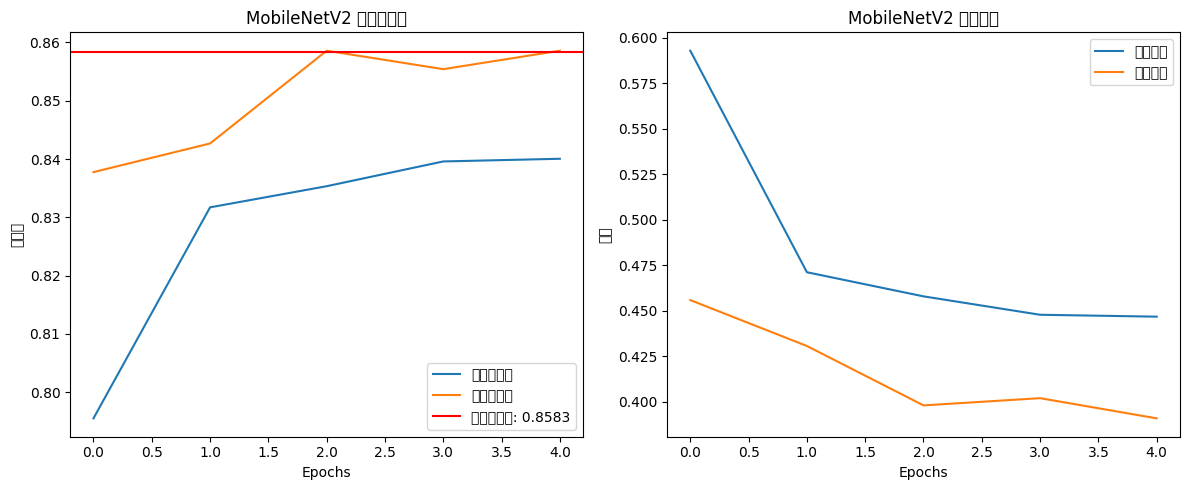

d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

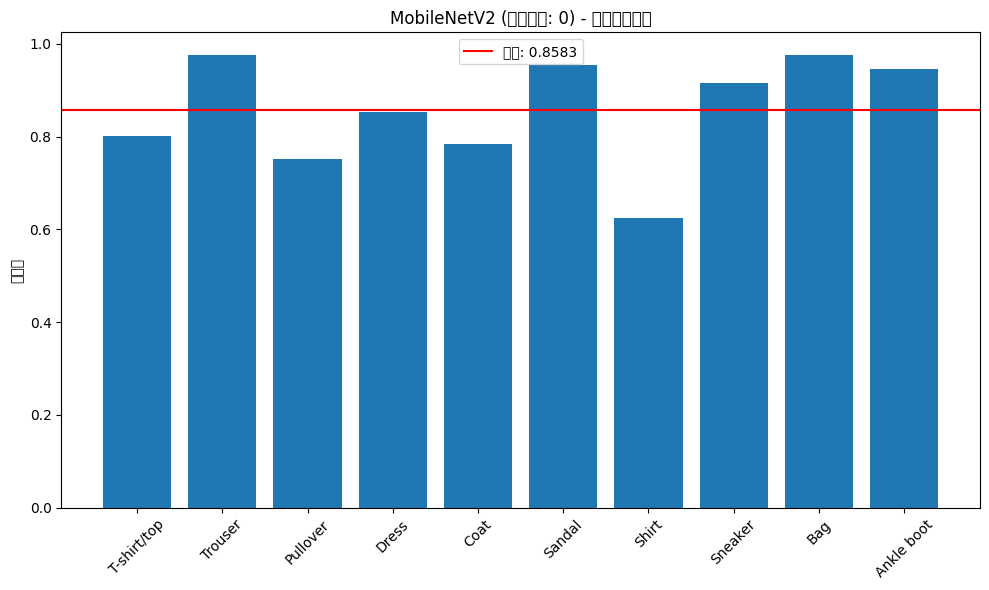

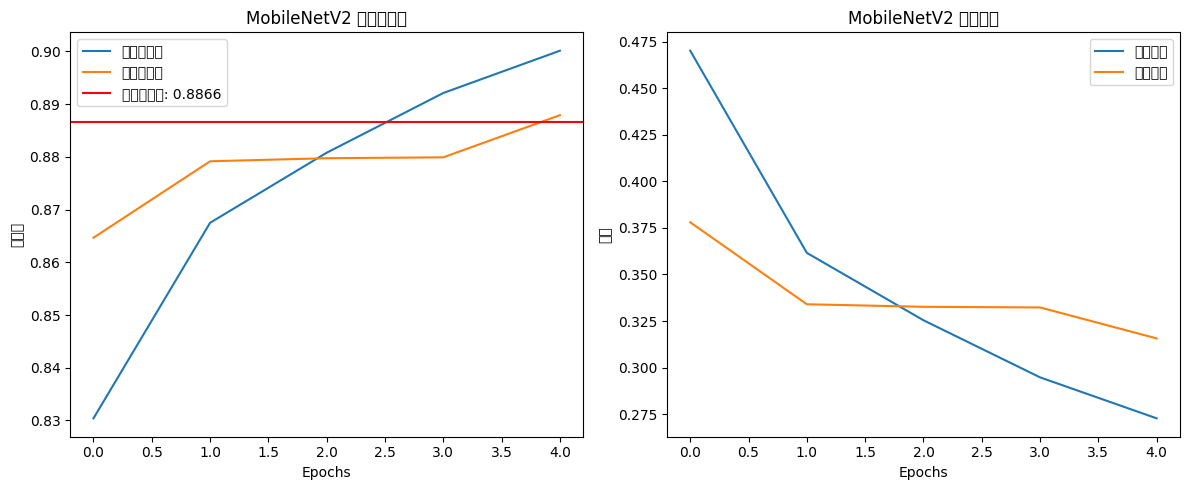

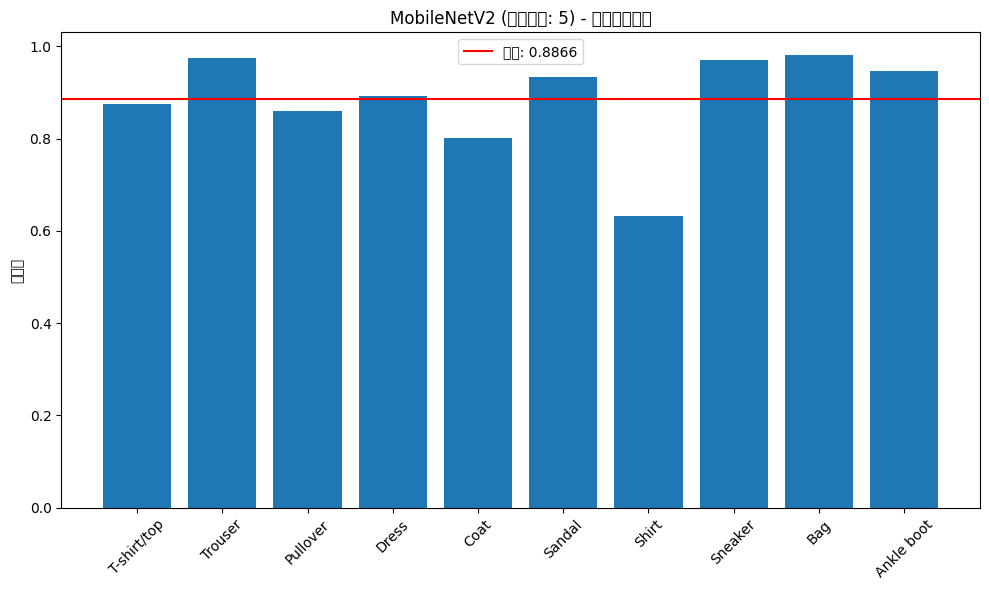

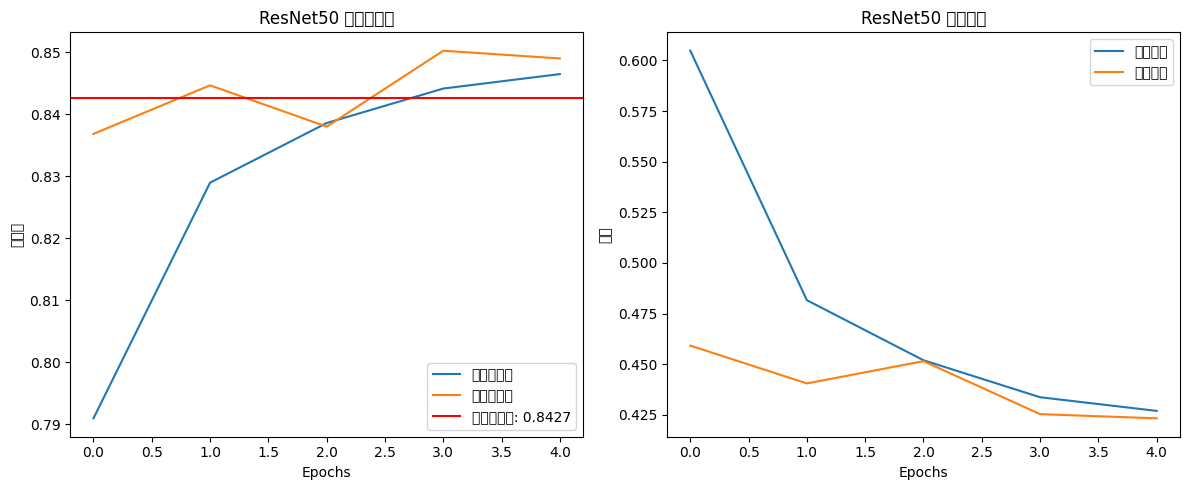

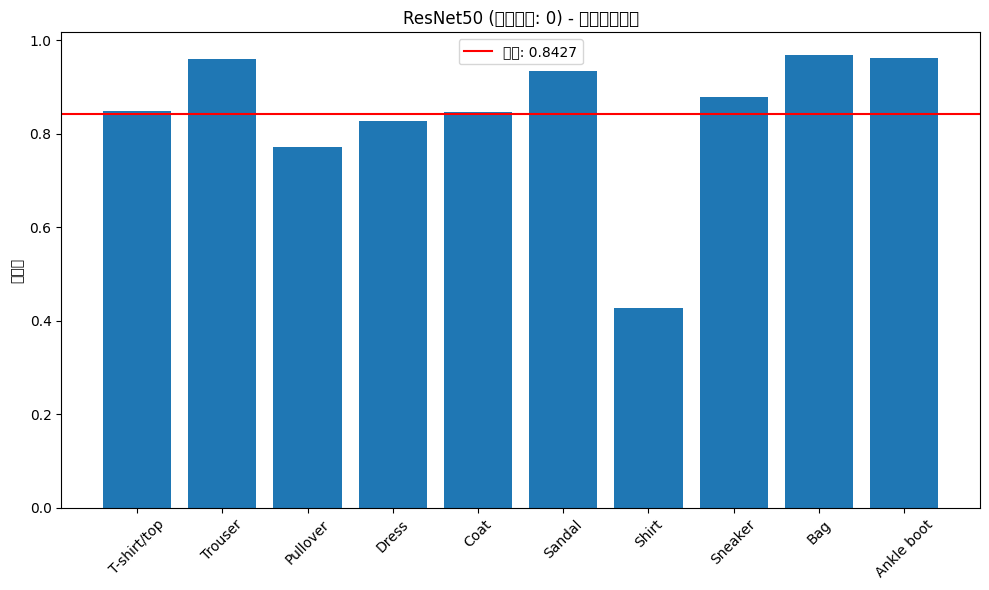

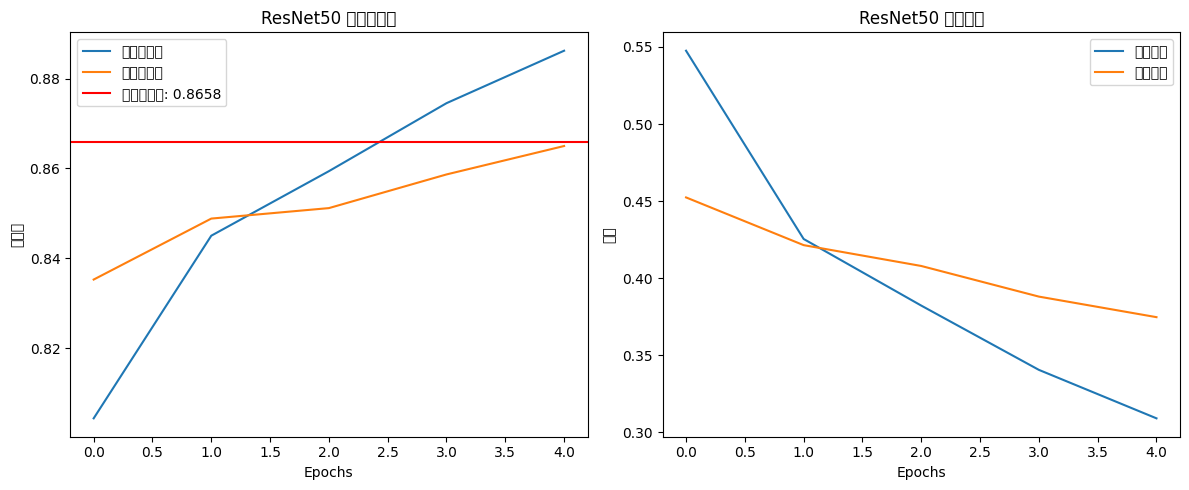

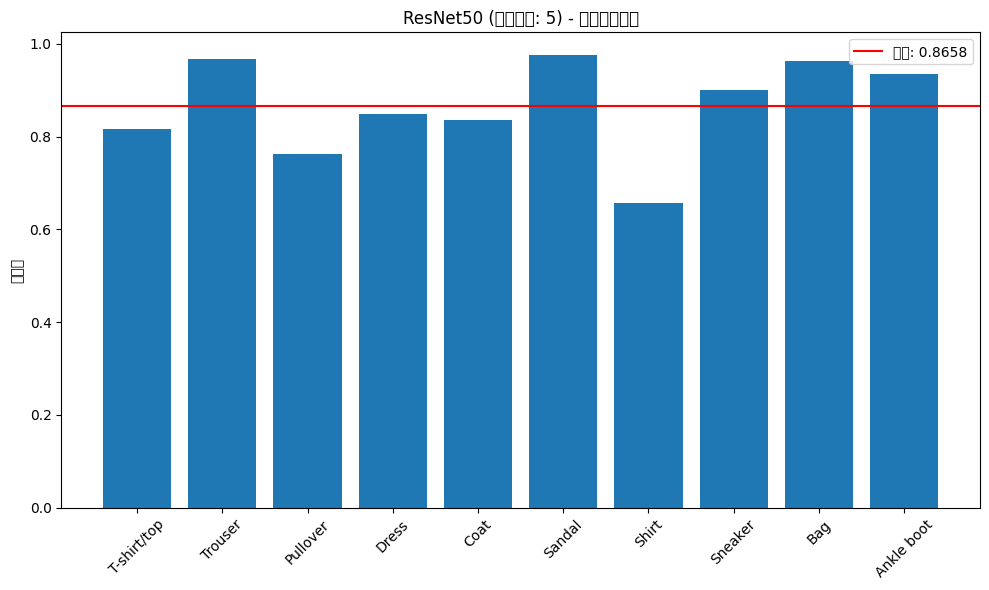

d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\vscode\1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

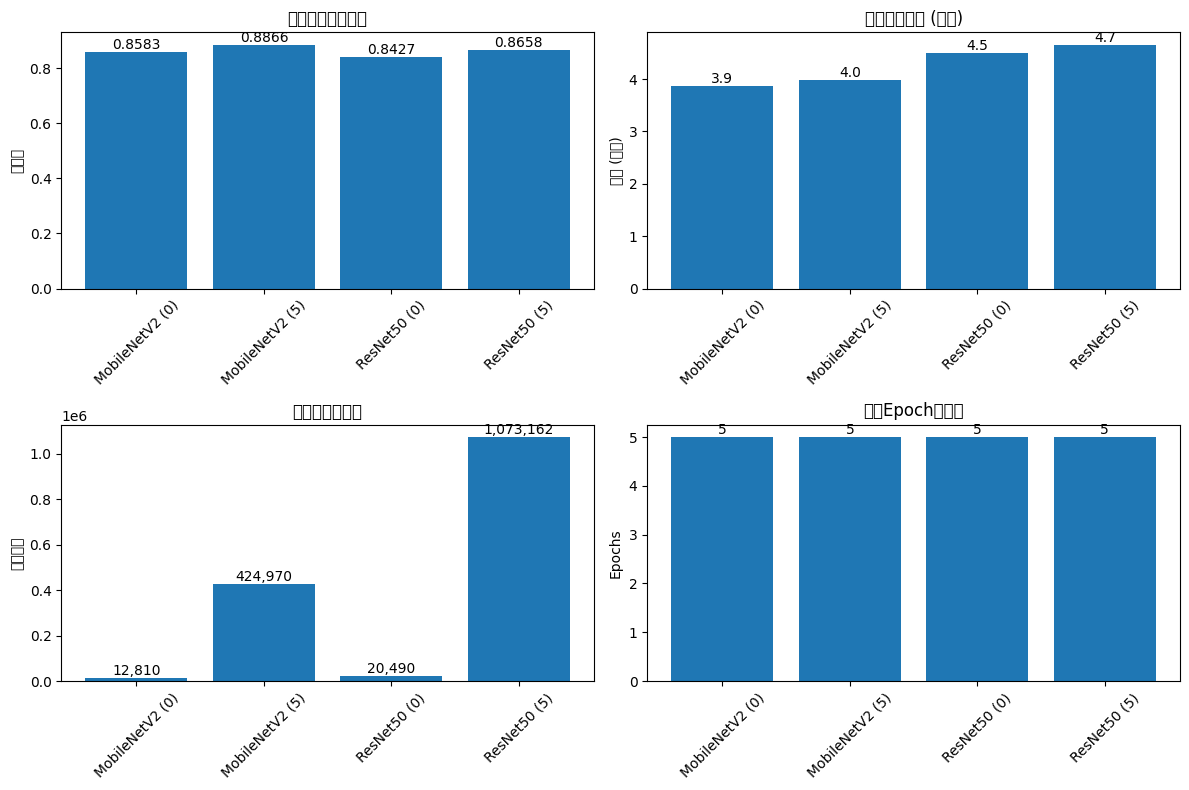

In [14]:
# 训练并评估不同模型配置
results = []


# MobileNetV2 - 不进行微调（所有层冻结）
mobilenet_results_frozen = train_and_evaluate_model(MobileNetTransferLearning, 'MobileNetV2', 0)
results.append(mobilenet_results_frozen)

# MobileNetV2 - 微调最后几层
mobilenet_results_finetuned = train_and_evaluate_model(MobileNetTransferLearning, 'MobileNetV2', 5)
results.append(mobilenet_results_finetuned)

# ResNet50 - 不进行微调（所有层冻结）
resnet50_results_frozen = train_and_evaluate_model(ResNet50TransferLearning, 'ResNet50', 0)
results.append(resnet50_results_frozen)

# ResNet50 - 微调最后几层
resnet50_results_finetuned = train_and_evaluate_model(ResNet50TransferLearning, 'ResNet50', 5)
results.append(resnet50_results_finetuned)

# 比较不同模型的性能
plt.figure(figsize=(12, 8))

# 比较测试准确率
plt.subplot(2, 2, 1)
model_names = [f"{r['model_name']} ({r['trainable_layers']})" for r in results]
accuracies = [r['test_accuracy'] for r in results]
bars = plt.bar(model_names, accuracies)
plt.title('测试集准确率对比')
plt.ylabel('准确率')
plt.xticks(rotation=45)
# 在柱状图上显示准确率数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom')

# 比较训练时间
plt.subplot(2, 2, 2)
training_times = [r['training_time'] / 60 for r in results]  # 转换为分钟
bars = plt.bar(model_names, training_times)
plt.title('训练时间对比 (分钟)')
plt.ylabel('时间 (分钟)')
plt.xticks(rotation=45)
# 在柱状图上显示时间数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom')

# 比较可训练参数数量
plt.subplot(2, 2, 3)
params = [r['trainable_params'] for r in results]
bars = plt.bar(model_names, params)
plt.title('可训练参数数量')
plt.ylabel('参数数量')
plt.xticks(rotation=45)
# 在柱状图上显示参数数量
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,}',
            ha='center', va='bottom')

# 比较训练的epoch数
plt.subplot(2, 2, 4)
epochs = [r['epochs'] for r in results]
bars = plt.bar(model_names, epochs)
plt.title('训练Epoch数对比')
plt.ylabel('Epochs')
plt.xticks(rotation=45)
# 在柱状图上显示epoch数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}',
            ha='center', va='bottom')

plt.tight_layout()
plt.savefig('results/models_comparison.png')

In [15]:


# 保存实验结果摘要
with open('results/experiment_summary.txt', 'w', encoding='utf-8') as f:
    f.write("Fashion-MNIST迁移学习实验结果摘要 (优化版)\n")
    f.write("====================================\n\n")
    
    for r in results:
        f.write(f"模型: {r['model_name']}\n")
        f.write(f"可训练层数: {r['trainable_layers']}\n")
        f.write(f"可训练参数数量: {r['trainable_params']:,}\n")
        f.write(f"测试准确率: {r['test_accuracy']:.4f}\n")
        f.write(f"训练时间: {r['training_time'] / 60:.2f} 分钟\n")
        f.write(f"训练Epoch数: {r['epochs']}\n")
        f.write(f"最佳验证准确率: {r['best_val_accuracy']:.4f}\n")
        f.write(f"最佳验证损失: {r['best_val_loss']:.4f}\n")
        f.write("\n各类别准确率:\n")
        for class_name, acc in r['class_accuracies']:
            f.write(f"  {class_name}: {acc:.4f}\n")
        f.write("------------------------------------\n\n")

# 创建模型对比表格
performance_table = "# 优化后的模型性能对比\n\n"
performance_table += "| 模型 | 可训练层数 | 可训练参数 | 测试准确率 | 训练时间(分钟) | Epochs |\n"
performance_table += "|------|------------|------------|------------|----------------|--------|\n"

for r in results:
    performance_table += f"| {r['model_name']} | {r['trainable_layers']} | {r['trainable_params']:,} | {r['test_accuracy']:.4f} | {r['training_time']/60:.2f} | {r['epochs']} |\n"

with open('results/performance_table.md', 'w', encoding='utf-8') as f:
    f.write(performance_table)

print("\n优化的迁移学习实验完成。结果已保存到 'results' 目录中。")


优化的迁移学习实验完成。结果已保存到 'results' 目录中。
